In [ ]:
import torch
import os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import opendatasets as od

In [ ]:
pip install opendatasets

# Chest X-Ray Images (Pneumonia)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [ ]:
od.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishvadhani
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:25<00:00, 95.4MB/s]


In [ ]:
os.listdir('./chest-xray-pneumonia/chest_xray/train')

['NORMAL', 'PNEUMONIA']

# Train Dataset

In [ ]:
train_dataset = ImageFolder('./chest-xray-pneumonia/chest_xray/train',
                            tt.Compose([tt.Resize(150),
                                        tt.CenterCrop(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()
                                        ]))

In [ ]:
def show_image(img, label):
  plt.imshow(img.permute(1,2,0))
  print('Label:',train_dataset.classes[label])

Label: NORMAL


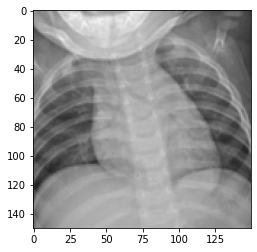

In [ ]:
show_image(*train_dataset[9])

In [ ]:
len(train_dataset)

5216

In [ ]:
train_dl = DataLoader(train_dataset,128,shuffle=True,num_workers=2,pin_memory=True)

# Validation Dataset

In [ ]:
test_dataset = ImageFolder('./chest-xray-pneumonia/chest_xray/val',
                            tt.Compose([tt.Resize(150),
                                        tt.CenterCrop(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()
                                        ]))

In [ ]:
test_dl = DataLoader(train_dataset,shuffle=True,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Test Dataset

In [ ]:
val_dataset = ImageFolder('./chest-xray-pneumonia/chest_xray/test',
                            tt.Compose([tt.Resize(150),
                                        tt.CenterCrop(150),
                                        tt.RandomHorizontalFlip(),
                                        tt.ToTensor()
                                        ]))

In [ ]:
val_dl = DataLoader(train_dataset,shuffle=True,num_workers=2,pin_memory=True)

# EDA

In [ ]:
def show_batch(train_dl):
  for img, label in train_dl:
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

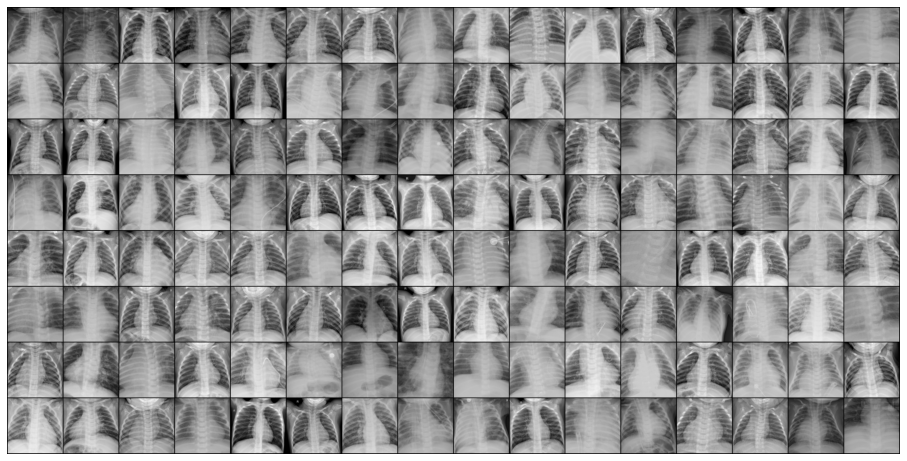

In [ ]:
show_batch(train_dl)

# Training Model

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    return loss

  def validation_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}   

  def validation_epoch_end(self,out):
    val_loss = [x['val_loss'] for x in out]
    epoch_loss = torch.stack(val_loss).mean()

    val_acc = [x['val_acc'] for x in out]
    epoch_acc = torch.stack(val_acc).mean()
    return {'val_loss':epoch_loss, 'val_acc':epoch_acc}

  def epoch_end(self,epoch,result):
    print('Epoch:[{}],val_loss:{},val_acc:{},train_loss:{}'.format(epoch,result['val_loss'],result['val_acc'],result['train_loss']))

In [ ]:
def accuracy(out, label):
  _, pred = torch.max(out, dim=1)
  return torch.tensor(torch.sum(pred==label)/len(pred))

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
def conv_block(in_channel, out_channel,pool=False):
  layers = [nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)]

  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers) 

In [ ]:
class Resnet9(ImageClassificationBase):
  def __init__(self,in_channel,num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channel,32)
    self.conv2 = conv_block(32,64,pool=True)
    self.res1 = nn.Sequential(conv_block(64,64),conv_block(64,64))

    self.conv3 = conv_block(64,128,pool=True)
    self.conv4 = conv_block(128,256,pool=True)
    self.res2 = nn.Sequential(conv_block(256,256),conv_block(256,256))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256*16,num_classes))
    
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out

In [ ]:
model = to_device(Resnet9(3,2),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [ ]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(out)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),max_lr)
    history = []
    torch.cuda.empty_cache()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        train_loss = []
        model.train()
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [ ]:
hist = [evaluate(model,val_dl)]
hist   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[{'val_acc': tensor(0.7429, device='cuda:0'),
  'val_loss': tensor(0.6836, device='cuda:0')}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam    

In [ ]:
hist += fit(epochs,model,1e-2,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:0.2078368067741394,val_acc:0.9344325065612793,train_loss:0.5130562782287598
Epoch:[1],val_loss:10.642289161682129,val_acc:0.25881901383399963,train_loss:0.1378130316734314
Epoch:[2],val_loss:0.22053176164627075,val_acc:0.9380751252174377,train_loss:0.4282861053943634
Epoch:[3],val_loss:0.10712490230798721,val_acc:0.9620398283004761,train_loss:0.22799448668956757
Epoch:[4],val_loss:0.09300384670495987,val_acc:0.972200870513916,train_loss:0.2136901468038559
Epoch:[5],val_loss:0.35516172647476196,val_acc:0.876725435256958,train_loss:0.1057911366224289
Epoch:[6],val_loss:0.08637240529060364,val_acc:0.9672162532806396,train_loss:0.09867722541093826
Epoch:[7],val_loss:0.08160684257745743,val_acc:0.9706671833992004,train_loss:0.07534343749284744
Epoch:[8],val_loss:0.046735722571611404,val_acc:0.9821702241897583,train_loss:0.05847495049238205
Epoch:[9],val_loss:0.04534135013818741,val_acc:0.9831287860870361,train_loss:0.05619271099567413


# we are getting an accuracy of 98.31%

In [ ]:
def plot_acc(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc,'-rx')
  plt.xlabel = 'epoch'
  plt.ylabel = 'accuracy'
  plt.title = 'accuracy vs epoch'

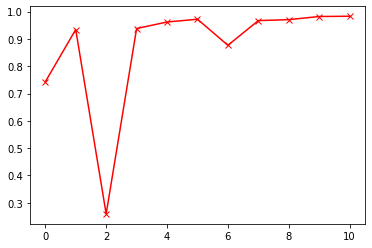

In [ ]:
plot_acc(hist)

In [ ]:
def plot_losses(history):
  val_loss = [x['val_loss'] for x in history]
  train_loss = [x.get('train_loss') for x in history]
  plt.plot(val_loss,'-rx')
  plt.plot(train_loss, '-y*')
  plt.xlabel = 'epoch'
  plt.ylabel = 'losses'
  plt.title = 'losses vs epoch'
  plt.legend(['Val_loss','train_loss'])

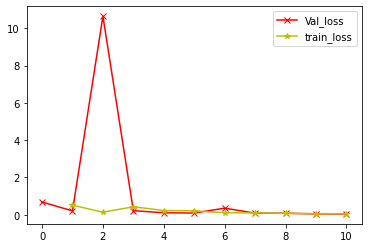

In [ ]:
plot_losses(hist)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, pred = torch.max(yb,dim=1)
    return train_dataset.classes[pred[0].item()]

In [ ]:
len(test_dataset)

16

Label: PNEUMONIA Prediction: PNEUMONIA


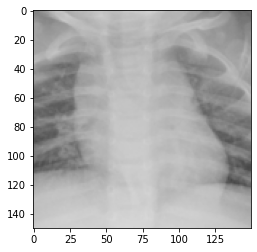

In [ ]:
img, label = test_dataset[10]
plt.imshow(img.permute(1,2,0))
print('Label:',train_dataset.classes[label],'Prediction:',predict_image(img,model))

In [ ]:
pip install jovian


     |████▊                           | 10 kB 23.8 MB/s eta 0:00:01
     |█████████▌                      | 20 kB 21.2 MB/s eta 0:00:01
     |██████████████▎                 | 30 kB 12.0 MB/s eta 0:00:01
     |███████████████████             | 40 kB 9.7 MB/s eta 0:00:01
     |███████████████████████▉        | 51 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████▋   | 61 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 3.2 MB/s 
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6501 sha256=c3459d566a90b9eb2cdec0a8861b1fe2dcc153f40d8fcb1bacde228af8165666
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [ ]:
jovian.commit()

NameError: ignored